In [2]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Scaling

In [1]:
# Define your scaling function
def custom_scaling(input_values):
    input_values_scaled = np.zeros_like(input_values, dtype=float)  # Initialize scaled data array
    input_values_scaled[:, 0] = (input_values[:, 0] - L_min) / (L_max - L_min)  # Scale L
    input_values_scaled[:, 1] = (input_values[:, 1] - C_min) / (C_max - C_min)  # Scale C
    input_values_scaled[:, 2] = (input_values[:, 2] - fsw_min) / (fsw_max - fsw_min)  # Scale fsw
    input_values_scaled[:, 3] = (input_values[:, 3] - t_dt_min) / (t_dt_max - t_dt_min) # Scale t_dt
    return input_values_scaled

# Define your scaling function
def custom_scaling_1(input_values):
    input_values_scaled = np.zeros_like(input_values, dtype=float)  # Initialize scaled data array
    input_values_scaled[:, 0] = (input_values[:, 0] - L_min) / (L_max - L_min)  # Scale L
    input_values_scaled[:, 1] = (input_values[:, 1] - C_min) / (C_max - C_min)  # Scale C
    input_values_scaled[:, 2] = (input_values[:, 2] - fsw_min) / (fsw_max - fsw_min)  # Scale fsw
    # input_values_scaled[:, 3] = (input_values[:, 3] - t_dt_min) / (t_dt_max - t_dt_min) # Scale t_dt
    return input_values_scaled

# 3 input 6 output

## Search N and H

In [9]:


# Fix random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load your simulation data
# Replace "your_dataset.csv" with the path to your dataset
df_1 = pd.read_csv(r"D:\Krishna\ai-power-converter\dataset\simulation_results_new.csv")

# Extract input features (L, C, fsw)
X_1 = df_1[['L', 'C', 'fsw']].values

# Extract output (ripples)
y_1 = df_1[["delta_current", "delta_voltage", "Pl_s1", "Pl_s2", "Pl_C", "Pl_L_Cu"]].values  # Adjust column names as per your dataset

# Define custom scaling ranges for each input feature
L_min, L_max = 30e-6, 2000e-6
C_min, C_max = 20e-6, 1000e-6
fsw_min, fsw_max = 20e3, 200e3
t_dt_min, t_dt_max = 0.178e-6, 1e-6

X_scaled = custom_scaling_1(X_1)

# Split the dataset into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y_1, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Define a custom callback to print custom information at the end of each epoch
class PrintEpochInfo(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch+1}/{self.params['epochs']}, Loss: {logs['loss']}, Val Loss: {logs['val_loss']}")


# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, verbose=1, mode='auto', restore_best_weights=True)

# Define the learning rate scheduler
lr_scheduler = ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-6)# Initialize a dictionary to store the training history for each configuration


histories_1 = {}

# Initialize dictionaries to store the evaluation metrics for each configuration
mses_1 = {}
maes_1 = {}
rmses_1= {}
r2_scores_1 = {}
mapes_1 = {}

# Define a list of different values for H and Nh to try
H_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]  # Number of hidden layers
Nh_values = [16, 32, 64, 128, 256, 512, 1024]  # Number of neurons per hidden layer



Epoch 1/100, Loss: 0.6956972479820251, Val Loss: 0.3528575599193573
Epoch 2/100, Loss: 0.2632943391799927, Val Loss: 0.21387991309165955
Epoch 3/100, Loss: 0.2551049292087555, Val Loss: 0.20993894338607788
Epoch 4/100, Loss: 0.2524164021015167, Val Loss: 0.2087385356426239
Epoch 5/100, Loss: 0.25012126564979553, Val Loss: 0.20626325905323029
Epoch 6/100, Loss: 0.2479998618364334, Val Loss: 0.20491249859333038
Epoch 7/100, Loss: 0.24719449877738953, Val Loss: 0.21918253600597382
Epoch 8/100, Loss: 0.24587537348270416, Val Loss: 0.20223768055438995
Epoch 9/100, Loss: 0.2453141212463379, Val Loss: 0.20036104321479797
Epoch 10/100, Loss: 0.24363403022289276, Val Loss: 0.19795653223991394
Epoch 11/100, Loss: 0.2405111938714981, Val Loss: 0.19507935643196106
Epoch 12/100, Loss: 0.2385087013244629, Val Loss: 0.188249409198761
Epoch 13/100, Loss: 0.23673884570598602, Val Loss: 0.18955372273921967
Epoch 14/100, Loss: 0.23413507640361786, Val Loss: 0.20087730884552002
Epoch 15/100, Loss: 0.231

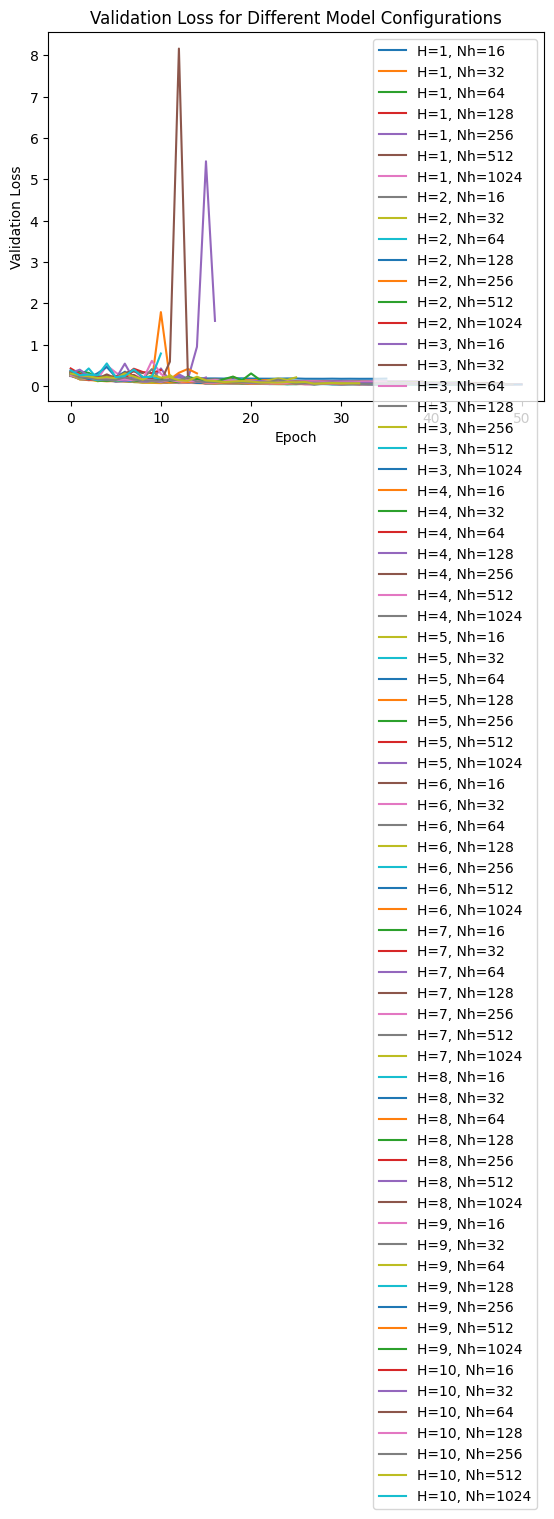

Model with H=1 and Nh=16:
MSE: 0.18545497953891754
MAE: 0.18545495629294895
RMSE: 0.6899935679523093
R-squared: 0.775497637939674
MAPE: 14.06254296103091%
Model with H=1 and Nh=32:
MSE: 0.14811590313911438
MAE: 0.14811590014241002
RMSE: 0.43510726100309194
R-squared: 0.8414392637909146
MAPE: 13.372254531665503%
Model with H=1 and Nh=64:
MSE: 0.1226380243897438
MAE: 0.12263802463932404
RMSE: 0.3725034601054109
R-squared: 0.936717479174027
MAPE: 9.127026755105366%
Model with H=1 and Nh=128:
MSE: 0.10739476978778839
MAE: 0.10739477450949418
RMSE: 0.3364772682190094
R-squared: 0.9456834126623943
MAPE: 7.683920131670647%
Model with H=1 and Nh=256:
MSE: 0.09890121966600418
MAE: 0.09890122575968452
RMSE: 0.31889742689960254
R-squared: 0.9516958354867325
MAPE: 6.854626248702471%
Model with H=1 and Nh=512:
MSE: 0.07631472498178482
MAE: 0.07631471967499887
RMSE: 0.2643960714654139
R-squared: 0.9644995473048925
MAPE: 5.688020614154084%
Model with H=1 and Nh=1024:
MSE: 0.07451873272657394
MAE: 0.0

In [10]:

# Iterate over different values of H and Nh
for H in H_values:
    for Nh in Nh_values:
        # Initialize a Sequential model
        model_1 = tf.keras.Sequential()

        # Add the first hidden layer with batch normalization
        model_1.add(tf.keras.layers.Dense(Nh, activation='relu', input_shape=(3,)))  
        model_1.add(tf.keras.layers.BatchNormalization())

        # Add subsequent hidden layers with batch normalization
        for _ in range(H - 1):
            model_1.add(tf.keras.layers.Dense(Nh, activation='relu'))
            model_1.add(tf.keras.layers.BatchNormalization())

        # Output layer (assuming it follows the hidden layers)
        model_1.add(tf.keras.layers.Dense(6, activation='softplus'))  

        # Compile the model
        model_1.compile(optimizer='adam', loss='mean_absolute_error')

        # Train the model and store the training history
    # Train the model with given hyperparameters
        history_1 = model_1.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), 
                        callbacks=[PrintEpochInfo(), lr_scheduler, early_stopping], verbose=0)
    
        histories_1[(H, Nh)] = history_1

        # Evaluate the model on the testing set
        predictions = model_1.predict(X_test)

        # Evaluate the model on the testing set and calculate MSE
        mse_1 = model_1.evaluate(X_test, y_test)
        mses_1[(H, Nh)] = mse_1

        # Calculate Mean Absolute Error (MAE)
        mae_1 = mean_absolute_error(y_test, predictions)
        maes_1[(H, Nh)] = mae_1

        # Calculate Root Mean Squared Error (RMSE)
        rmse_1 = np.sqrt(mean_squared_error(y_test, predictions))
        rmses_1[(H, Nh)] = rmse_1

        # Calculate R-squared (R2) Score
        r2_1 = r2_score(y_test, predictions)
        r2_scores_1[(H, Nh)] = r2_1

        # Calculate Mean Absolute Percentage Error (MAPE)
        mape_1 = np.mean(np.abs((y_test - predictions) / y_test)) * 100
        mapes_1[(H, Nh)] = mape_1

# Plot the validation loss for each configuration
for (H, Nh), history_1 in histories_1.items():
    plt.plot(history_1.history['val_loss'], label=f'H={H}, Nh={Nh}')

plt.title('Validation Loss for Different Model Configurations')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()
plt.show()

# Print the MSE for each configuration
# Print the evaluation metrics for each configuration
for (H, Nh), mse_1 in mses_1.items():
    print(f'Model with H={H} and Nh={Nh}:')
    print(f'MSE: {mse_1}')
    print(f'MAE: {maes_1[(H, Nh)]}')
    print(f'RMSE: {rmses_1[(H, Nh)]}')
    print(f'R-squared: {r2_scores_1[(H, Nh)]}')
    print(f'MAPE: {mapes_1[(H, Nh)]}%')


### Ranking

In [11]:
# Rank combinations based on their MSE values
ranked_combinations_1 = sorted(mses_1.items(), key=lambda x: x[1])

# Print ranked combinations
for idx, ((H, Nh), mse_1) in enumerate(ranked_combinations_1, start=1):
    print(f"Rank {idx}: Combination H={H}, Nh={Nh} - MSE: {mse_1}")


Rank 1: Combination H=3, Nh=512 - MSE: 0.03880980238318443
Rank 2: Combination H=3, Nh=256 - MSE: 0.04070647433400154
Rank 3: Combination H=3, Nh=1024 - MSE: 0.04095173254609108
Rank 4: Combination H=2, Nh=1024 - MSE: 0.04394692927598953
Rank 5: Combination H=7, Nh=256 - MSE: 0.04428607225418091
Rank 6: Combination H=4, Nh=128 - MSE: 0.04507841542363167
Rank 7: Combination H=9, Nh=128 - MSE: 0.045920196920633316
Rank 8: Combination H=5, Nh=256 - MSE: 0.04661376774311066
Rank 9: Combination H=2, Nh=512 - MSE: 0.046905435621738434
Rank 10: Combination H=2, Nh=256 - MSE: 0.04829058796167374
Rank 11: Combination H=6, Nh=64 - MSE: 0.04902487248182297
Rank 12: Combination H=5, Nh=128 - MSE: 0.04955557733774185
Rank 13: Combination H=6, Nh=256 - MSE: 0.04966847598552704
Rank 14: Combination H=10, Nh=256 - MSE: 0.04976970702409744
Rank 15: Combination H=8, Nh=256 - MSE: 0.050008274614810944
Rank 16: Combination H=6, Nh=512 - MSE: 0.05041439086198807
Rank 17: Combination H=9, Nh=256 - MSE: 0.05

### Try spesific N and H

In [6]:
# Specify the combination you want to call
H = 7
Nh = 512

# Retrieve the model for the specified combination
selected_model_1 = histories_1[(H, Nh)].model
selected_model_1.save("model_7_512_13_13.h5")
# Use the trained model to make predictions on the testing set
predictions_1 = selected_model_1.predict(X_test)

# Evaluate the model on the testing set
mse_1 = selected_model_1.evaluate(X_test, y_test)
print("Mean Squared Error on Testing Set:", mse_1)

# Print the first few predictions
print("Predictions:")
print(predictions_1[:5])

# Print the corresponding true values
print("True Values:")
print(y_test[:5])

NameError: name 'histories' is not defined

# 4 input 7 output

## Search N and H

In [19]:


# Fix random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load your simulation data
# Replace "your_dataset.csv" with the path to your dataset
df = pd.read_csv(r"D:\Krishna\ai-power-converter\dataset\simulation_results_13x13x13x13.csv")

# Extract input features (L, C, fsw)
X = df[['L', 'C', 'fsw', "t_dt"]].values

# Extract output (ripples)
y = df[["delta_current", "delta_voltage", "Pl_s1", "Pl_s2", "Pl_C", "Pl_L_Cu", "P_D"]].values  # Adjust column names as per your dataset

# Define custom scaling ranges for each input feature
L_min, L_max = 30e-6, 2000e-6
C_min, C_max = 20e-6, 1000e-6
fsw_min, fsw_max = 20e3, 200e3
t_dt_min, t_dt_max = 0.178e-6, 1e-6

X_scaled = custom_scaling(X)

# Split the dataset into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Define a custom callback to print custom information at the end of each epoch
class PrintEpochInfo(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch+1}/{self.params['epochs']}, Loss: {logs['loss']}, Val Loss: {logs['val_loss']}")


# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, verbose=1, mode='auto', restore_best_weights=True)

# Define the learning rate scheduler
lr_scheduler = ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-6)# Initialize a dictionary to store the training history for each configuration


histories = {}

# Initialize dictionaries to store the evaluation metrics for each configuration
mses = {}
maes = {}
rmses = {}
r2_scores = {}
mapes = {}

# Define a list of different values for H and Nh to try
H_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]  # Number of hidden layers
Nh_values = [16, 32, 64, 128, 256, 512, 1024]  # Number of neurons per hidden layer

Epoch 1/100, Loss: 467.29046630859375, Val Loss: 307.91119384765625
Epoch 2/100, Loss: 275.1830139160156, Val Loss: 148.23512268066406
Epoch 3/100, Loss: 176.76382446289062, Val Loss: 88.87483978271484
Epoch 4/100, Loss: 125.21340942382812, Val Loss: 53.286155700683594
Epoch 5/100, Loss: 95.07276916503906, Val Loss: 33.6619873046875
Epoch 6/100, Loss: 73.85726928710938, Val Loss: 21.88969612121582
Epoch 7/100, Loss: 60.44194030761719, Val Loss: 15.250088691711426
Epoch 8/100, Loss: 49.667823791503906, Val Loss: 12.755078315734863
Epoch 9/100, Loss: 43.312591552734375, Val Loss: 14.586673736572266
Epoch 10/100, Loss: 38.53387451171875, Val Loss: 10.936214447021484
Epoch 11/100, Loss: 35.337623596191406, Val Loss: 14.038070678710938
Epoch 12/100, Loss: 31.374208450317383, Val Loss: 16.743026733398438
Epoch 13/100, Loss: 27.556570053100586, Val Loss: 14.190906524658203
Epoch 14/100, Loss: 29.975027084350586, Val Loss: 16.191001892089844
Epoch 15/100, Loss: 26.410533905029297, Val Loss: 20

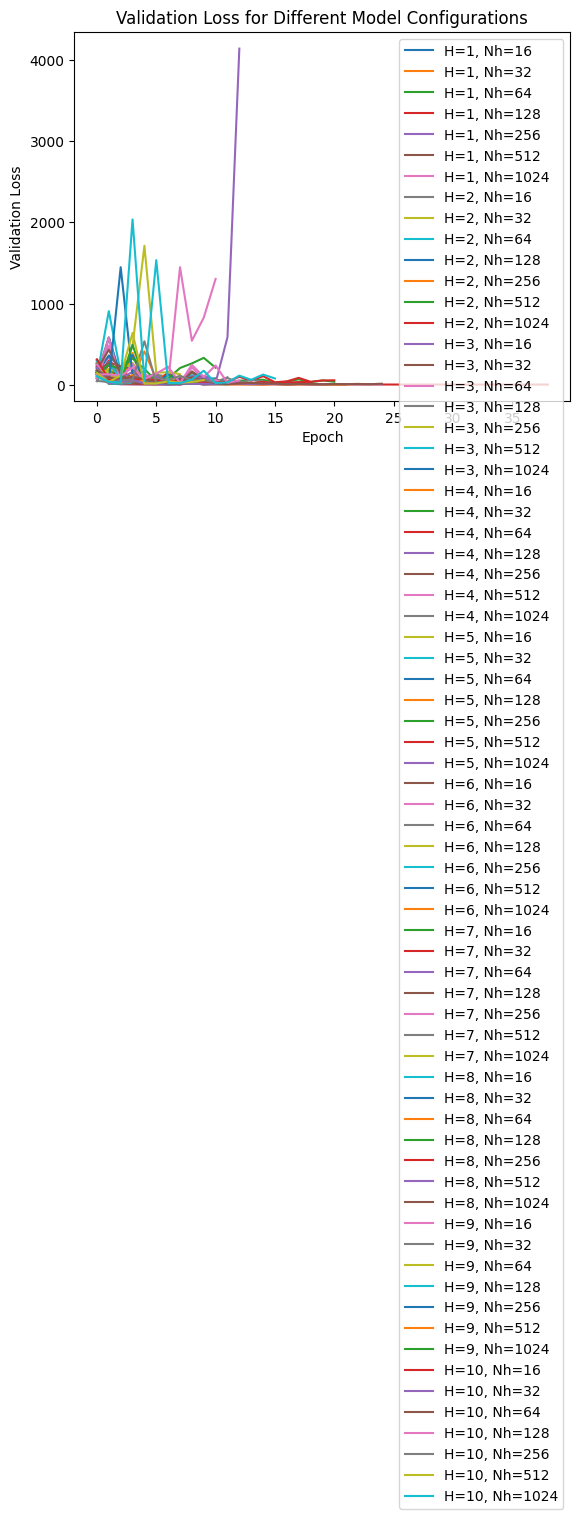

Model with H=1 and Nh=16:
MSE: 12.876541137695312
MAE: 1.0542664567534157
RMSE: 3.5883895081188464
R-squared: 0.6080568005906654
MAPE: 75.48553890087177%
Model with H=1 and Nh=32:
MSE: 10.122145652770996
MAE: 0.8542082078526784
RMSE: 3.181532462106484
R-squared: 0.692946094148106
MAPE: 39.96114616923284%
Model with H=1 and Nh=64:
MSE: 11.11303424835205
MAE: 0.9718069885493762
RMSE: 3.333621620717094
R-squared: 0.7318595559526555
MAPE: 39.80110435170393%
Model with H=1 and Nh=128:
MSE: 9.919990539550781
MAE: 0.8647445048730262
RMSE: 3.1496021210045764
R-squared: 0.7470711296223477
MAPE: 35.53158212871124%
Model with H=1 and Nh=256:
MSE: 7.888583183288574
MAE: 0.7617139366468145
RMSE: 2.808661830959334
R-squared: 0.7777369910481173
MAPE: 26.45101182163487%
Model with H=1 and Nh=512:
MSE: 6.409819602966309
MAE: 0.6646062736299456
RMSE: 2.53176183728271
R-squared: 0.8035880138467179
MAPE: 24.891458481815498%
Model with H=1 and Nh=1024:
MSE: 6.722057819366455
MAE: 0.6670215999696903
RMSE: 2

In [20]:

# Iterate over different values of H and Nh
for H in H_values:
    for Nh in Nh_values:
        # Initialize a Sequential model
        model = tf.keras.Sequential()

        # Add the first hidden layer with batch normalization
        model.add(tf.keras.layers.Dense(Nh, activation='relu', input_shape=(4,)))  
        model.add(tf.keras.layers.BatchNormalization())

        # Add subsequent hidden layers with batch normalization
        for _ in range(H - 1):
            model.add(tf.keras.layers.Dense(Nh, activation='relu'))
            model.add(tf.keras.layers.BatchNormalization())

        # Output layer (assuming it follows the hidden layers)
        model.add(tf.keras.layers.Dense(7, activation='softplus'))  

        # Compile the model
        model.compile(optimizer='adam', loss='mean_squared_error')

        # Train the model and store the training history
    # Train the model with given hyperparameters
        history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), 
                        callbacks=[PrintEpochInfo(), lr_scheduler, early_stopping], verbose=0)
    
        histories[(H, Nh)] = history

        # Evaluate the model on the testing set
        predictions = model.predict(X_test)

        # Evaluate the model on the testing set and calculate MSE
        mse = model.evaluate(X_test, y_test)
        mses[(H, Nh)] = mse

        # Calculate Mean Absolute Error (MAE)
        mae = mean_absolute_error(y_test, predictions)
        maes[(H, Nh)] = mae

        # Calculate Root Mean Squared Error (RMSE)
        rmse = np.sqrt(mean_squared_error(y_test, predictions))
        rmses[(H, Nh)] = rmse

        # Calculate R-squared (R2) Score
        r2 = r2_score(y_test, predictions)
        r2_scores[(H, Nh)] = r2

        # Calculate Mean Absolute Percentage Error (MAPE)
        mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100
        mapes[(H, Nh)] = mape

# Plot the validation loss for each configuration
for (H, Nh), history in histories.items():
    plt.plot(history.history['val_loss'], label=f'H={H}, Nh={Nh}')

plt.title('Validation Loss for Different Model Configurations')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()
plt.show()

# Print the MSE for each configuration
# Print the evaluation metrics for each configuration
for (H, Nh), mse in mses.items():
    print(f'Model with H={H} and Nh={Nh}:')
    print(f'MSE: {mse}')
    print(f'MAE: {maes[(H, Nh)]}')
    print(f'RMSE: {rmses[(H, Nh)]}')
    print(f'R-squared: {r2_scores[(H, Nh)]}')
    print(f'MAPE: {mapes[(H, Nh)]}%')


### Ranking

In [21]:
# Rank combinations based on their MSE values
ranked_combinations = sorted(mses.items(), key=lambda x: x[1])

# Print ranked combinations
for idx, ((H, Nh), mse) in enumerate(ranked_combinations, start=1):
    print(f"Rank {idx}: Combination H={H}, Nh={Nh} - MSE: {mse}")


Rank 1: Combination H=3, Nh=64 - MSE: 3.489384889602661
Rank 2: Combination H=4, Nh=64 - MSE: 3.6607136726379395
Rank 3: Combination H=6, Nh=1024 - MSE: 3.8289339542388916
Rank 4: Combination H=6, Nh=64 - MSE: 4.020104885101318
Rank 5: Combination H=8, Nh=64 - MSE: 5.854841232299805
Rank 6: Combination H=1, Nh=512 - MSE: 6.409819602966309
Rank 7: Combination H=5, Nh=1024 - MSE: 6.444264888763428
Rank 8: Combination H=1, Nh=1024 - MSE: 6.722057819366455
Rank 9: Combination H=4, Nh=1024 - MSE: 7.2853875160217285
Rank 10: Combination H=7, Nh=1024 - MSE: 7.485689163208008
Rank 11: Combination H=5, Nh=64 - MSE: 7.538564205169678
Rank 12: Combination H=10, Nh=32 - MSE: 7.579972743988037
Rank 13: Combination H=1, Nh=256 - MSE: 7.888583183288574
Rank 14: Combination H=10, Nh=64 - MSE: 8.07089900970459
Rank 15: Combination H=5, Nh=256 - MSE: 8.760366439819336
Rank 16: Combination H=8, Nh=1024 - MSE: 8.887612342834473
Rank 17: Combination H=4, Nh=128 - MSE: 9.123793601989746
Rank 18: Combination

In [ ]:
RELU; softplus; adam; mae

Rank 1: Combination H=4, Nh=1024 - MSE: 0.26322445273399353
Rank 2: Combination H=6, Nh=256 - MSE: 0.27132970094680786
Rank 3: Combination H=5, Nh=512 - MSE: 0.27443310618400574
Rank 4: Combination H=6, Nh=512 - MSE: 0.2859092950820923
Rank 5: Combination H=7, Nh=256 - MSE: 0.2886124849319458
Rank 6: Combination H=4, Nh=256 - MSE: 0.29380303621292114
Rank 7: Combination H=3, Nh=256 - MSE: 0.3013882637023926
Rank 8: Combination H=3, Nh=128 - MSE: 0.30243438482284546
Rank 9: Combination H=5, Nh=256 - MSE: 0.3103891611099243
Rank 10: Combination H=4, Nh=512 - MSE: 0.31600332260131836
Rank 11: Combination H=6, Nh=128 - MSE: 0.3344302773475647
Rank 12: Combination H=7, Nh=128 - MSE: 0.33630120754241943
Rank 13: Combination H=3, Nh=1024 - MSE: 0.3374582529067993
Rank 14: Combination H=8, Nh=256 - MSE: 0.338657408952713
Rank 15: Combination H=5, Nh=1024 - MSE: 0.3497074246406555
Rank 16: Combination H=4, Nh=128 - MSE: 0.36127668619155884
Rank 17: Combination H=5, Nh=128 - MSE: 0.3649902045726776
Rank 18: Combination H=3, Nh=512 - MSE: 0.3689928948879242
Rank 19: Combination H=6, Nh=1024 - MSE: 0.36962857842445374
Rank 20: Combination H=9, Nh=64 - MSE: 0.370402455329895
Rank 21: Combination H=8, Nh=64 - MSE: 0.370433509349823
Rank 22: Combination H=8, Nh=128 - MSE: 0.37228918075561523
Rank 23: Combination H=5, Nh=64 - MSE: 0.378347247838974
Rank 24: Combination H=4, Nh=64 - MSE: 0.3934590220451355
Rank 25: Combination H=8, Nh=512 - MSE: 0.3983493745326996
Rank 26: Combination H=7, Nh=64 - MSE: 0.40309301018714905
Rank 27: Combination H=6, Nh=64 - MSE: 0.4091455042362213
Rank 28: Combination H=9, Nh=128 - MSE: 0.41415321826934814
Rank 29: Combination H=10, Nh=64 - MSE: 0.42383238673210144
Rank 30: Combination H=3, Nh=64 - MSE: 0.42932531237602234
Rank 31: Combination H=9, Nh=512 - MSE: 0.44648751616477966
Rank 32: Combination H=6, Nh=32 - MSE: 0.4497069716453552
Rank 33: Combination H=10, Nh=128 - MSE: 0.4497949182987213
Rank 34: Combination H=7, Nh=512 - MSE: 0.4504418969154358
Rank 35: Combination H=5, Nh=32 - MSE: 0.4559937119483948
Rank 36: Combination H=8, Nh=1024 - MSE: 0.4715973138809204
Rank 37: Combination H=9, Nh=256 - MSE: 0.47251656651496887
Rank 38: Combination H=7, Nh=1024 - MSE: 0.4733339250087738
Rank 39: Combination H=7, Nh=32 - MSE: 0.5089122653007507
Rank 40: Combination H=4, Nh=32 - MSE: 0.5270136594772339
Rank 41: Combination H=10, Nh=512 - MSE: 0.5316060781478882
Rank 42: Combination H=3, Nh=32 - MSE: 0.5365204811096191
Rank 43: Combination H=10, Nh=32 - MSE: 0.5388094186782837
Rank 44: Combination H=8, Nh=32 - MSE: 0.5455743074417114
Rank 45: Combination H=5, Nh=16 - MSE: 0.5709627270698547
Rank 46: Combination H=2, Nh=64 - MSE: 0.5927831530570984
Rank 47: Combination H=9, Nh=16 - MSE: 0.5968542695045471
Rank 48: Combination H=1, Nh=512 - MSE: 0.5985084772109985
Rank 49: Combination H=9, Nh=32 - MSE: 0.5994222164154053
Rank 50: Combination H=1, Nh=1024 - MSE: 0.6033295392990112
Rank 51: Combination H=2, Nh=256 - MSE: 0.6056203246116638
Rank 52: Combination H=2, Nh=32 - MSE: 0.6085751056671143
Rank 53: Combination H=10, Nh=16 - MSE: 0.6110162138938904
Rank 54: Combination H=7, Nh=16 - MSE: 0.6239843964576721
Rank 55: Combination H=1, Nh=256 - MSE: 0.6305482387542725
Rank 56: Combination H=9, Nh=1024 - MSE: 0.6467861533164978
Rank 57: Combination H=2, Nh=1024 - MSE: 0.6516326665878296
Rank 58: Combination H=2, Nh=128 - MSE: 0.6548219919204712
Rank 59: Combination H=6, Nh=16 - MSE: 0.6551449298858643
Rank 60: Combination H=10, Nh=1024 - MSE: 0.6557344794273376
Rank 61: Combination H=1, Nh=128 - MSE: 0.6564121246337891
Rank 62: Combination H=4, Nh=16 - MSE: 0.6590310335159302
Rank 63: Combination H=2, Nh=512 - MSE: 0.6614372730255127
Rank 64: Combination H=1, Nh=64 - MSE: 0.6766181588172913
Rank 65: Combination H=10, Nh=256 - MSE: 0.6776650547981262
Rank 66: Combination H=8, Nh=16 - MSE: 0.6814402341842651
Rank 67: Combination H=3, Nh=16 - MSE: 0.691008985042572
Rank 68: Combination H=1, Nh=32 - MSE: 0.7285468578338623
Rank 69: Combination H=2, Nh=16 - MSE: 0.7406852841377258
Rank 70: Combination H=1, Nh=16 - MSE: 0.7689734101295471

RELU; softplus; adam; mse
Rank 1: Combination H=3, Nh=64 - MSE: 3.489384889602661
Rank 2: Combination H=4, Nh=64 - MSE: 3.6607136726379395
Rank 3: Combination H=6, Nh=1024 - MSE: 3.8289339542388916
Rank 4: Combination H=6, Nh=64 - MSE: 4.020104885101318
Rank 5: Combination H=8, Nh=64 - MSE: 5.854841232299805
Rank 6: Combination H=1, Nh=512 - MSE: 6.409819602966309
Rank 7: Combination H=5, Nh=1024 - MSE: 6.444264888763428
Rank 8: Combination H=1, Nh=1024 - MSE: 6.722057819366455
Rank 9: Combination H=4, Nh=1024 - MSE: 7.2853875160217285
Rank 10: Combination H=7, Nh=1024 - MSE: 7.485689163208008
Rank 11: Combination H=5, Nh=64 - MSE: 7.538564205169678
Rank 12: Combination H=10, Nh=32 - MSE: 7.579972743988037
Rank 13: Combination H=1, Nh=256 - MSE: 7.888583183288574
Rank 14: Combination H=10, Nh=64 - MSE: 8.07089900970459
Rank 15: Combination H=5, Nh=256 - MSE: 8.760366439819336
Rank 16: Combination H=8, Nh=1024 - MSE: 8.887612342834473
Rank 17: Combination H=4, Nh=128 - MSE: 9.123793601989746
Rank 18: Combination H=8, Nh=256 - MSE: 9.555337905883789
Rank 19: Combination H=8, Nh=512 - MSE: 9.901229858398438
Rank 20: Combination H=1, Nh=128 - MSE: 9.919990539550781
Rank 21: Combination H=1, Nh=32 - MSE: 10.122145652770996
Rank 22: Combination H=6, Nh=32 - MSE: 10.280619621276855
Rank 23: Combination H=3, Nh=32 - MSE: 10.397319793701172
Rank 24: Combination H=4, Nh=256 - MSE: 10.419577598571777
Rank 25: Combination H=7, Nh=64 - MSE: 10.64047622680664
Rank 26: Combination H=6, Nh=256 - MSE: 10.649297714233398
Rank 27: Combination H=1, Nh=64 - MSE: 11.11303424835205
Rank 28: Combination H=2, Nh=32 - MSE: 11.212749481201172
Rank 29: Combination H=9, Nh=256 - MSE: 11.291604042053223
Rank 30: Combination H=5, Nh=32 - MSE: 11.365772247314453
Rank 31: Combination H=5, Nh=16 - MSE: 11.849995613098145
Rank 32: Combination H=9, Nh=1024 - MSE: 11.851866722106934
Rank 33: Combination H=3, Nh=16 - MSE: 11.934191703796387
Rank 34: Combination H=3, Nh=1024 - MSE: 12.411211013793945
Rank 35: Combination H=7, Nh=32 - MSE: 12.449151992797852
Rank 36: Combination H=8, Nh=32 - MSE: 12.63925552368164
Rank 37: Combination H=1, Nh=16 - MSE: 12.876541137695312
Rank 38: Combination H=4, Nh=32 - MSE: 12.915886878967285
Rank 39: Combination H=9, Nh=512 - MSE: 13.177522659301758
Rank 40: Combination H=7, Nh=128 - MSE: 13.372401237487793
Rank 41: Combination H=7, Nh=512 - MSE: 13.543766021728516
Rank 42: Combination H=2, Nh=16 - MSE: 13.921812057495117
Rank 43: Combination H=3, Nh=256 - MSE: 14.10563850402832
Rank 44: Combination H=7, Nh=256 - MSE: 14.136628150939941
Rank 45: Combination H=5, Nh=128 - MSE: 14.787274360656738
Rank 46: Combination H=7, Nh=16 - MSE: 14.990870475769043
Rank 47: Combination H=4, Nh=512 - MSE: 15.124505996704102
Rank 48: Combination H=10, Nh=512 - MSE: 15.308294296264648
Rank 49: Combination H=9, Nh=32 - MSE: 15.525466918945312
Rank 50: Combination H=3, Nh=128 - MSE: 17.207027435302734
Rank 51: Combination H=10, Nh=1024 - MSE: 17.484464645385742
Rank 52: Combination H=10, Nh=16 - MSE: 18.81040382385254
Rank 53: Combination H=6, Nh=128 - MSE: 18.85356330871582
Rank 54: Combination H=3, Nh=512 - MSE: 19.048036575317383
Rank 55: Combination H=5, Nh=512 - MSE: 19.491788864135742
Rank 56: Combination H=9, Nh=128 - MSE: 19.9486026763916
Rank 57: Combination H=2, Nh=512 - MSE: 20.522382736206055
Rank 58: Combination H=9, Nh=16 - MSE: 21.564191818237305
Rank 59: Combination H=6, Nh=16 - MSE: 22.531558990478516
Rank 60: Combination H=10, Nh=128 - MSE: 22.557525634765625
Rank 61: Combination H=2, Nh=128 - MSE: 24.43372917175293
Rank 62: Combination H=10, Nh=256 - MSE: 24.55689811706543
Rank 63: Combination H=8, Nh=16 - MSE: 24.687105178833008
Rank 64: Combination H=2, Nh=64 - MSE: 27.268346786499023
Rank 65: Combination H=6, Nh=512 - MSE: 29.60325813293457
Rank 66: Combination H=4, Nh=16 - MSE: 34.04990768432617
Rank 67: Combination H=2, Nh=1024 - MSE: 36.365299224853516
Rank 68: Combination H=2, Nh=256 - MSE: 40.69628143310547
Rank 69: Combination H=8, Nh=128 - MSE: 45.57101058959961
Rank 70: Combination H=9, Nh=64 - MSE: 61.29008102416992


### Try spesific N and H

In [15]:
# Specify the combination you want to call
H = 4
Nh = 1024

# Retrieve the model for the specified combination
selected_model = histories[(H, Nh)].model
selected_model.save("model_4_1024_13_13_.h5")
# Use the trained model to make predictions on the testing set
predictions = selected_model.predict(X_test)

# Evaluate the model on the testing set
mse = selected_model.evaluate(X_test, y_test)
print("Mean Squared Error on Testing Set:", mse)

# Print the first few predictions
print("Predictions:")
print(predictions[:5])

# Print the corresponding true values
print("True Values:")
print(y_test[:5])

 34/134 [======>.......................] - ETA: 0s

d:\Krishna\Python_3_92\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


134/134 [==============================] - 0s 1ms/step - loss: 0.2632
Mean Squared Error on Testing Set: 0.26322445273399353
Predictions:
[[4.94520950e+00 6.25322044e-01 1.68957520e+00 1.68046486e+00
  2.01721862e-02 8.67017448e-01 1.18278064e-01]
 [1.83744469e+01 5.52549744e+00 1.34882081e+00 1.32561815e+00
  1.79472018e-03 2.01359794e-01 1.25890061e-01]
 [1.68494320e+01 2.72182584e+00 1.88195705e+00 1.87190425e+00
  8.98849592e-03 4.47230458e-01 1.21876158e-01]
 [4.47842789e+00 1.19853151e+00 2.08799934e+00 2.08096504e+00
  7.64500443e-03 8.53145063e-01 1.17788926e-01]
 [2.03854942e+01 6.47426367e+00 1.94576478e+00 1.93830419e+00
  2.34065540e-02 1.04791844e+00 3.53775956e-02]]
True Values:
[[4.76080528e+00 5.25655146e-01 1.67239255e+00 1.67239255e+00
  1.99805977e-02 9.73727435e-01 1.21483470e-01]
 [2.13022187e+01 4.20957287e+00 1.32108197e+00 1.32108197e+00
  9.90812382e-04 1.72777606e-01 1.30921004e-01]
 [1.65742053e+01 2.70162061e+00 1.91680832e+00 1.91680832e+00
  9.07691085e-03

# Machine Learning

Epoch 1/100, Loss: 2.2866857051849365, Val Loss: 2.571958541870117
Epoch 2/100, Loss: 1.9187602996826172, Val Loss: 3.4091126918792725
Epoch 3/100, Loss: 1.7702720165252686, Val Loss: 1.2799644470214844
Epoch 4/100, Loss: 1.6664124727249146, Val Loss: 1.0638561248779297
Epoch 5/100, Loss: 1.7233836650848389, Val Loss: 1.4774147272109985
Epoch 6/100, Loss: 1.6873492002487183, Val Loss: 2.0373520851135254
Epoch 7/100, Loss: 1.6562879085540771, Val Loss: 1.2898961305618286
Epoch 8/100, Loss: 1.5521819591522217, Val Loss: 1.081950306892395
Epoch 9/100, Loss: 1.5038197040557861, Val Loss: 0.8322009444236755
Epoch 10/100, Loss: 1.4938000440597534, Val Loss: 1.2523847818374634
Epoch 11/100, Loss: 1.458170771598816, Val Loss: 1.1327825784683228
Epoch 12/100, Loss: 1.489689826965332, Val Loss: 1.087729811668396
Epoch 13/100, Loss: 1.4055639505386353, Val Loss: 0.6505082249641418
Epoch 14/100, Loss: 1.4112576246261597, Val Loss: 0.7315927743911743
Epoch 15/100, Loss: 1.4098701477050781, Val Loss

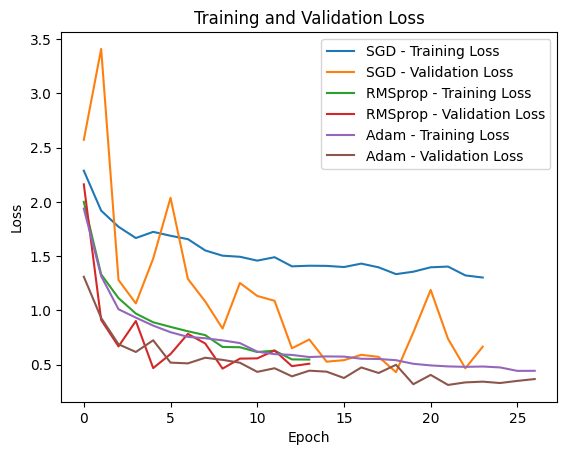

In [40]:
# Load your simulation data
# Replace "your_dataset.csv" with the path to your dataset
df = pd.read_csv(r"D:\Krishna\ai-power-converter\dataset\simulation_results_13x13x13x13.csv")

# Extract input features (L, C, fsw)
X = df[['L', 'C', 'fsw', "t_dt"]].values

# Extract output (ripples)
y = df[["delta_current", "delta_voltage", "Pl_s1", "Pl_s2", "Pl_C", "Pl_L_Cu", "P_D"]].values  # Adjust column names as per your dataset

# Define custom scaling ranges for each input feature
L_min, L_max = 30e-6, 2000e-6
C_min, C_max = 20e-6, 1000e-6
fsw_min, fsw_max = 20e3, 200e3
t_dt_min, t_dt_max = 0.178e-6, 1e-6

# Apply custom scaling
X_scaled = custom_scaling(X)

# Split the dataset into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Define a custom callback to print custom information at the end of each epoch
class PrintEpochInfo(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch+1}/{self.params['epochs']}, Loss: {logs['loss']}, Val Loss: {logs['val_loss']}")

# Assuming you have already defined your machine learning model and dataset
# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, verbose=1, mode='auto', restore_best_weights=True)

# Define the learning rate scheduler
lr_scheduler = ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-6)

# Import the required optimizers
from tensorflow.keras.optimizers import SGD, RMSprop

# Define the models with different optimizers
model_sgd = tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation='relu', input_shape=(4,)),  
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(512, activation='relu'), 
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(512, activation='relu'), 
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(7, activation='softplus')                               
])

model_rmsprop = tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation='relu', input_shape=(4,)),  
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(512, activation='relu'), 
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(512, activation='relu'), 
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(7, activation='softplus')                               
])

model_adam = tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation='relu', input_shape=(4,)),  
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(512, activation='relu'), 
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(512, activation='relu'), 
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(7, activation='softplus')                               
])

# Compile the models with different optimizers
sgd_optimizer = SGD(learning_rate=0.01, momentum=0.9)
model_sgd.compile(optimizer=sgd_optimizer, loss='mean_absolute_error')

rmsprop_optimizer = RMSprop(learning_rate=0.001)
model_rmsprop.compile(optimizer=rmsprop_optimizer, loss='mean_absolute_error')


model_adam.compile(optimizer='adam', loss='mean_absolute_error')

# Train the models with given hyperparameters
history_sgd = model_sgd.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), 
                        callbacks=[PrintEpochInfo(), lr_scheduler, early_stopping], verbose=0)

history_rmsprop = model_rmsprop.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), 
                        callbacks=[PrintEpochInfo(), lr_scheduler, early_stopping], verbose=0)


history_adam = model_adam.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), 
                        callbacks=[PrintEpochInfo(), lr_scheduler, early_stopping], verbose=0)
# Plot training and validation loss for all models
plt.plot(history_sgd.history['loss'], label='SGD - Training Loss')
plt.plot(history_sgd.history['val_loss'], label='SGD - Validation Loss')
plt.plot(history_rmsprop.history['loss'], label='RMSprop - Training Loss')
plt.plot(history_rmsprop.history['val_loss'], label='RMSprop - Validation Loss')
plt.plot(history_adam.history['loss'], label='Adam - Training Loss')
plt.plot(history_adam.history['val_loss'], label='Adam - Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
# Import the required module for weight initialization
# from tensorflow.keras.initializers import GlorotUniform, HeNormal, RandomNormal

# # Initialize different weight initializers
# glorot_uniform_initializer = GlorotUniform()  # Glorot (Xavier) Uniform initializer
# he_normal_initializer = HeNormal()            # He Normal initializer
# random_normal_initializer = RandomNormal(mean=0.0, stddev=0.05)  # Random Normal initializer

# # Define your model with different initialization techniques
# model_glorot_uniform = tf.keras.Sequential([
#     tf.keras.layers.Dense(512, activation='relu', kernel_initializer=glorot_uniform_initializer, input_shape=(4,)),  
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dense(512, activation='relu', kernel_initializer=glorot_uniform_initializer), 
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dense(512, activation='relu', kernel_initializer=glorot_uniform_initializer), 
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dense(7, activation='softplus', kernel_initializer=glorot_uniform_initializer)                               
# ])

# model_he_normal = tf.keras.Sequential([
#     tf.keras.layers.Dense(512, activation='relu', kernel_initializer=he_normal_initializer, input_shape=(4,)),  
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dense(512, activation='relu', kernel_initializer=he_normal_initializer), 
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dense(512, activation='relu', kernel_initializer=he_normal_initializer), 
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dense(7, activation='softplus', kernel_initializer=he_normal_initializer)                               
# ])

# model_random_normal = tf.keras.Sequential([
#     tf.keras.layers.Dense(512, activation='relu', kernel_initializer=random_normal_initializer, input_shape=(4,)),  
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dense(512, activation='relu', kernel_initializer=random_normal_initializer), 
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dense(512, activation='relu', kernel_initializer=random_normal_initializer), 
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dense(7, activation='softplus', kernel_initializer=random_normal_initializer)                               
# ])

# # Compile the models
# model_glorot_uniform.compile(optimizer='adam', loss='mean_absolute_error')
# model_he_normal.compile(optimizer='adam', loss='mean_absolute_error')
# model_random_normal.compile(optimizer='adam', loss='mean_absolute_error')

# # Train the models with given hyperparameters
# history_glorot_uniform = model_glorot_uniform.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), 
#                         callbacks=[PrintEpochInfo(), lr_scheduler, early_stopping], verbose=0)

# history_he_normal = model_he_normal.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), 
#                         callbacks=[PrintEpochInfo(), lr_scheduler, early_stopping], verbose=0)

# history_random_normal = model_random_normal.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), 
#                         callbacks=[PrintEpochInfo(), lr_scheduler, early_stopping], verbose=0)

# # Define your model with default weight initialization
# model_default = tf.keras.Sequential([
#     tf.keras.layers.Dense(512, activation='relu', input_shape=(4,)),  
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dense(512, activation='relu'), 
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dense(512, activation='relu'), 
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dense(7, activation='softplus')                               
# ])

# # Compile the default model
# model_default.compile(optimizer='adam', loss='mean_absolute_error')

# # Train the default model with given hyperparameters
# history_default = model_default.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), 
#                         callbacks=[PrintEpochInfo(), lr_scheduler, early_stopping], verbose=0)

# # Plot training and validation loss for all models
# plt.plot(history_glorot_uniform.history['loss'], label='Glorot Uniform - Training Loss')
# plt.plot(history_glorot_uniform.history['val_loss'], label='Glorot Uniform - Validation Loss')
# plt.plot(history_he_normal.history['loss'], label='He Normal - Training Loss')
# plt.plot(history_he_normal.history['val_loss'], label='He Normal - Validation Loss')
# plt.plot(history_random_normal.history['loss'], label='Random Normal - Training Loss')
# plt.plot(history_random_normal.history['val_loss'], label='Random Normal - Validation Loss')
# plt.plot(history_default.history['loss'], label='Default Initialization - Training Loss')
# plt.plot(history_default.history['val_loss'], label='Default Initialization - Validation Loss')
# plt.title('Training and Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()


# model = tf.keras.Sequential([
#     tf.keras.layers.Dense(512, activation='relu', input_shape=(4,)),  # Scalarization layer         # Hidden layer 1
#     tf.keras.layers.BatchNormalization(),                  # Batch normalization
#     tf.keras.layers.Dense(512, activation='relu'),          # Hidden layer 2
#     tf.keras.layers.BatchNormalization(),                  # Batch normalization
#     tf.keras.layers.Dense(512, activation='relu'),          # Hidden layer 2
#     tf.keras.layers.BatchNormalization(),         
#     tf.keras.layers.Dense(7, activation='softplus')                               # Output layer with 6 neurons
# ])

# # Compile the model
# model.compile(optimizer='adam', loss='mean_absolute_error')

#     # Train the model with given hyperparameters
# history = model.fit(X_train, y_train, epochs=100, batch_size=128, validation_data=(X_val, y_val), 
#                         callbacks=[PrintEpochInfo(), lr_scheduler, early_stopping], verbose=0)
    
# # Plot training and validation loss
# plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.title('Training and Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

In [42]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

# Function to print evaluation metrics
def print_evaluation_metrics(model_name, y_true, y_pred):
    # Calculate Mean Absolute Error (MAE)
    mae = mean_absolute_error(y_true, y_pred)
    print(f'{model_name} - Mean Absolute Error (MAE): {mae}')

    # Calculate Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f'{model_name} - Root Mean Squared Error (RMSE): {rmse}')

    # Calculate R-squared (R2) Score
    r2 = r2_score(y_true, y_pred)
    print(f'{model_name} - R-squared (R2) Score: {r2}')

    # Calculate Mean Absolute Percentage Error (MAPE)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print(f'{model_name} - Mean Absolute Percentage Error (MAPE): {mape}%')

y_preds_sgd = model_sgd.predict(X_test)
print_evaluation_metrics("SGD: ", y_test, y_preds_sgd)

y_preds_rms = model_rmsprop.predict(X_test)
print_evaluation_metrics("RMS: ", y_test, y_preds_rms)

y_preds_adam = model_adam.predict(X_test)
print_evaluation_metrics("Adam: ", y_test, y_preds_adam)
# # Evaluate and print metrics for models with different initializations
# y_preds_glorot = model_glorot_uniform.predict(X_test)
# print_evaluation_metrics("Glorot Uniform Initialization", y_test, y_preds_glorot)

# y_preds_he = model_he_normal.predict(X_test)
# print_evaluation_metrics("He Normal Initialization", y_test, y_preds_he)

# y_preds_random = model_random_normal.predict(X_test)
# print_evaluation_metrics("Random Normal Initialization", y_test, y_preds_random)

# y_preds_default = model_default.predict(X_test)
# print_evaluation_metrics("Default Initialization", y_test, y_preds_default)


  1/134 [..............................] - ETA: 1s

134/134 [==============================] - 0s 814us/step
SGD:  - Mean Absolute Error (MAE): 0.43898154945239254
SGD:  - Root Mean Squared Error (RMSE): 3.725622902537418
SGD:  - R-squared (R2) Score: 0.9206215351447321
SGD:  - Mean Absolute Percentage Error (MAPE): 13.00797529246692%
134/134 [==============================] - 0s 758us/step
RMS:  - Mean Absolute Error (MAE): 0.4269416430012994
RMS:  - Root Mean Squared Error (RMSE): 3.4107964150444703
RMS:  - R-squared (R2) Score: 0.45879753480037583
RMS:  - Mean Absolute Percentage Error (MAPE): 13.682616146546414%
134/134 [==============================] - 0s 752us/step
Adam:  - Mean Absolute Error (MAE): 0.32357779335584425
Adam:  - Root Mean Squared Error (RMSE): 2.197102459961686
Adam:  - R-squared (R2) Score: -9.519926582117549
Adam:  - Mean Absolute Percentage Error (MAPE): 20.96380243851731%


## Testing Set

In [31]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

# Evaluate the model on the testing set
mse = model.evaluate(X_test, y_test)
print("Mean Squared Error on Testing Set:", mse)

# Use the trained model to make predictions on the testing set
predictions = model.predict(X_test)

# # Print the first few predictions
# print("Predictions:")
# print(predictions[:5])

# # Print the corresponding true values
# print("True Values:")
# print(y_test[:5])

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, predictions)
print(f'Mean Absolute Error (MAE): {mae}')

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Calculate R-squared (R2) Score
r2 = r2_score(y_test, predictions)
print(f'R-squared (R2) Score: {r2}')

# Calculate Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100
print(f'Mean Absolute Percentage Error (MAPE): {mape}%')

  1/134 [..............................] - ETA: 1s - loss: 0.3383

134/134 [==============================] - 0s 828us/step - loss: 0.2739
Mean Squared Error on Testing Set: 0.2739008665084839
134/134 [==============================] - 0s 840us/step
Mean Absolute Error (MAE): 0.27390079014170265
Root Mean Squared Error (RMSE): 1.9634872386854565
R-squared (R2) Score: 0.6528700251194317
Mean Absolute Percentage Error (MAPE): 11.044990309908982%


In [ ]:
3;512;relu,sofplus;adam;mse

  1/134 [..............................] - ETA: 2s - loss: 4.1512
134/134 [==============================] - 0s 817us/step - loss: 27.7646
Mean Squared Error on Testing Set: 27.76456069946289
134/134 [==============================] - 0s 848us/step
Mean Absolute Error (MAE): 0.7581576547763414
Root Mean Squared Error (RMSE): 5.269208690486307
R-squared (R2) Score: 0.8208782877857594
Mean Absolute Percentage Error (MAPE): 57.71760416123496%

3;512;relu,sofplus;adam;mae
  1/134 [..............................] - ETA: 1s - loss: 0.3389
134/134 [==============================] - 0s 919us/step - loss: 0.3031
Mean Squared Error on Testing Set: 0.3031238317489624
134/134 [==============================] - 0s 837us/step
Mean Absolute Error (MAE): 0.30312381956750395
Root Mean Squared Error (RMSE): 2.470368101428276
R-squared (R2) Score: 0.6560031149928386
Mean Absolute Percentage Error (MAPE): 11.848394450503182%

3;512;relu,sofplus;adam;mean_squared_logarithmic_error
134/134 [==============================] - 0s 830us/step - loss: 0.0018
Mean Squared Error on Testing Set: 0.0017645122716203332
134/134 [==============================] - 0s 815us/step
Mean Absolute Error (MAE): 0.37385278368516184
Root Mean Squared Error (RMSE): 3.9613237519924422
R-squared (R2) Score: 0.9189070923319173
Mean Absolute Percentage Error (MAPE): 13.070327890105634%

3;512;relu,sofplus;adam;huber
Mean Squared Error on Testing Set: 0.23930767178535461
134/134 [==============================] - 0s 802us/step
Mean Absolute Error (MAE): 0.3807023679892415
Root Mean Squared Error (RMSE): 1.8392098203772433
R-squared (R2) Score: 0.8540626486855839
Mean Absolute Percentage Error (MAPE): 36.78694640382704%

3;512;relu,sofplus;adam;mae; batch=64
Mean Squared Error on Testing Set: 0.2610272765159607
134/134 [==============================] - 0s 825us/step
Mean Absolute Error (MAE): 0.26102725067580435
Root Mean Squared Error (RMSE): 1.7660875080208822
R-squared (R2) Score: 0.9773669706553136
Mean Absolute Percentage Error (MAPE): 8.604452441417386%

3;512;relu,sofplus;adam;mae; batch=128
Mean Squared Error on Testing Set: 0.2739008665084839
134/134 [==============================] - 0s 840us/step
Mean Absolute Error (MAE): 0.27390079014170265
Root Mean Squared Error (RMSE): 1.9634872386854565
R-squared (R2) Score: 0.6528700251194317
Mean Absolute Percentage Error (MAPE): 11.044990309908982%

## Save Model

In [ ]:
# Evaluate the model on the testing set
mse = model.evaluate(X_test, y_test)
print("Mean Squared Error on Testing Set:", mse)

# Optionally, save the model
model.save("ripples_prediction_model.h5")
